In [1]:
from helpers import NormalizedEnv
from helpers import RandomAgent
import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch

import importlib
from helpers import NormalizedEnv

#### 3 Heuristic policy
Define a simple heuristic policy to (attempt to) stabilize the pendulum. 
By comparing the heuristic policy with a random policy, verify that it leads to an increase in average reward.

In [2]:
#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

#Create random agent
Random_Agent = RandomAgent(pendulum)

In [5]:
#Episode

def run_episode(agent = Random_Agent):
  current_state = pendulum.reset()[0]
  max_it = False
  i = 0
  total_reward = 0
  while not max_it:
    # The instructions state that trunc becomes True once max_it has been surpassed
    # The source code however outputs a False statically, hence this break section of code
    if i >= 200:
      max_it = True
      break

    action = agent.compute_action(state = current_state)
    transformed_action = pendulum.action(action)
    next_state, reward, term, trunc, info = pendulum.step(transformed_action)

    current_state = next_state
    i += 1
    total_reward += reward
  return total_reward

In [6]:
#Execute 10 episodes with random agent

reward_vector_random_agent = []
for j in range(10):
  total_reward = run_episode()
  reward_vector_random_agent.append(total_reward)
print("The average cumulative reward obtained:", np.mean(reward_vector_random_agent))

c:\Users\User\anaconda3\envs\ann\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


The average cumulative reward obtained: -1208.5025884195263


In [7]:
#Implementation of heuristic policy

class HeuristicPendulumAgent:
  def __init__(self, env, fixed_torque = 1):
    self.state_size = env.observation_space.shape[0]
    self.action_size = env.action_space.shape[0]
    self.fixed_torque = fixed_torque
  def compute_action(self, state):
    x,y,theta = state
    if x < 0:
      action = np.sign(theta)*self.fixed_torque
    else:
      action = -np.sign(theta)*self.fixed_torque
    return action
  

In [8]:
# Run 10 episodes with heuristic policy
#Execute 10 episodes with random agent

heuristic_agent = HeuristicPendulumAgent(pendulum)

reward_vector_heuristic_agent = []
for j in range(10):
  total_reward = run_episode(agent = heuristic_agent)
  reward_vector_heuristic_agent.append(total_reward)
print(np.mean(reward_vector_heuristic_agent))

-487.8053875081482


In [9]:
np.arange(0,1,0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

[-1343.6773057680778, -379.26889232212784]


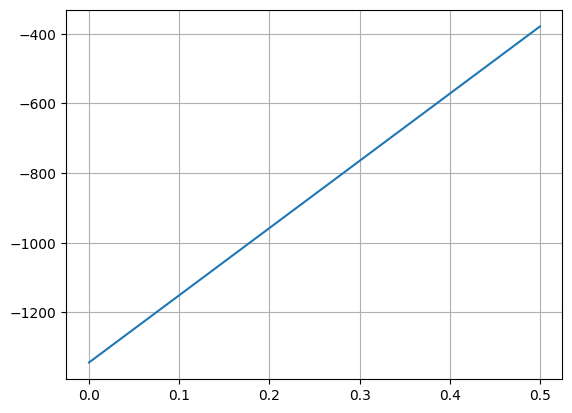

In [10]:
#effect of fixed_torque amplitude on mean reward of one episode
reward_vector_heuristic_agent_varying_torque = []
torque = np.arange(0,1,0.5)
for t in torque:
  heuristic_agent = HeuristicPendulumAgent(pendulum, fixed_torque = t)
  reward_vector_heuristic_agent = []
  for j in range(1):
    total_reward = run_episode(agent = heuristic_agent)
    reward_vector_heuristic_agent.append(total_reward)
    #print(reward_vector_heuristic_agent)
  reward_vector_heuristic_agent_varying_torque.append(np.mean(reward_vector_heuristic_agent))
print(reward_vector_heuristic_agent_varying_torque)

plt.plot(torque, reward_vector_heuristic_agent_varying_torque)
plt.grid()
#plt.xticks(np.arange(0,1,0.1))

[-1196.7509955636, -1027.5708327407433, -661.4093355889008, -586.9262660152096, -452.56094987055, -460.17055573816634, -428.98286419759626, -439.68459735411295, -485.34125257602136, -381.912239644975]


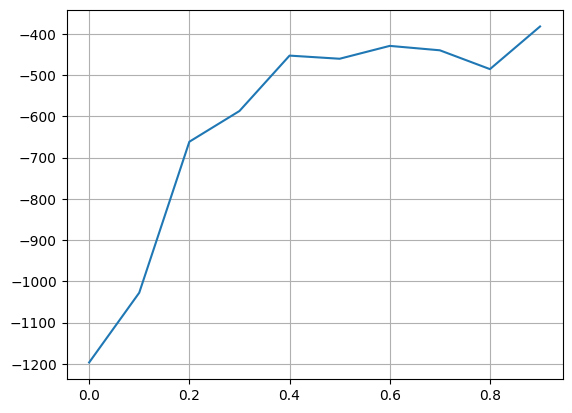

In [11]:
#effect of fixed_torque amplitude on mean reward of one episode
reward_vector_heuristic_agent_varying_torque = []
torque = np.arange(0,1,0.1)
for t in torque:
  heuristic_agent = HeuristicPendulumAgent(pendulum, fixed_torque = t)
  reward_vector_heuristic_agent = []
  for j in range(10):
    total_reward = run_episode(agent = heuristic_agent)
    reward_vector_heuristic_agent.append(total_reward)
    #print(reward_vector_heuristic_agent)
  reward_vector_heuristic_agent_varying_torque.append(np.mean(reward_vector_heuristic_agent))
print(reward_vector_heuristic_agent_varying_torque)

plt.plot(torque, reward_vector_heuristic_agent_varying_torque)
plt.grid()
#plt.xticks(np.arange(0,1,0.1))

[-1087.8477483321146, -1046.6698506387518, -798.0125891442203, -744.6287598538365, -705.1744656384652, -518.547116080731, -495.6420137930131, -460.09138845729484, -490.046656501097, -419.4205348054247, -434.6352502651456, -433.06887004237797, -382.2486341798351, -374.9295589558708, -458.6958555336593, -439.32039918256226, -440.23280502979185, -364.3021313826258, -392.1606879299574, -450.6732530382763]


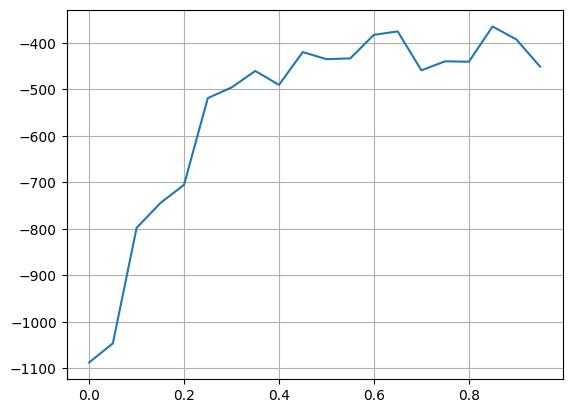

In [12]:
#effect of fixed_torque amplitude on mean reward of one episode
reward_vector_heuristic_agent_varying_torque = []
torque = np.arange(0,1,0.05)
for t in torque:
  heuristic_agent = HeuristicPendulumAgent(pendulum, fixed_torque = t)
  reward_vector_heuristic_agent = []
  for j in range(10):
    total_reward = run_episode(agent = heuristic_agent)
    reward_vector_heuristic_agent.append(total_reward)
    #print(reward_vector_heuristic_agent)
  reward_vector_heuristic_agent_varying_torque.append(np.mean(reward_vector_heuristic_agent))
print(reward_vector_heuristic_agent_varying_torque)

plt.plot(torque, reward_vector_heuristic_agent_varying_torque)
plt.grid()

#plt.xticks(np.arange(0,1,0.1))

#### 4 Q function of the heuristic policy

In [13]:
#Implementation of Replaybuffer

class ReplayBuffer:
  def __init__(self, max_size = 200):
    self.state_buffer = []
    self.action_buffer = []
    self.reward_buffer = []
    self.next_state_buffer = []
    self.max_size = max_size
  
  def add_transition(self, state, action, reward, next_state, trunc):
    self.state_buffer.append(state)
    self.action_buffer.append(action)
    self.reward_buffer.append(reward)
    self.next_state_buffer.append(next_state)
    if len(self.state_buffer) > self.max_size:
      self.state_buffer.pop(0)
      self.action_buffer.pop(0)
      self.reward_buffer.pop(0)
      self.next_state_buffer.pop(0)

  def sample_transition(self, index):
    transitions = []
    for i in index:
      transitions.append((self.state_buffer[i], self.action_buffer[i], self.reward_buffer[i], self.next_state_buffer[i], False))
    return transitions



In [14]:
#implementation of QNetwork
import torch.nn as nn

class QNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.Lin1 = nn.Linear(4,32)
    self.Relu1 = nn.ReLU()
    self.Lin2 = nn.Linear(32,32)
    self.Relu1 = nn.ReLU() # add
    self.Lin3 = nn.Linear(32,1)

  def forward(self,x):
    x = self.Lin1(x)
    x = self.Relu1(x)
    x = self.Lin2(x)
    x = self.Relu1(x)
    x = self.Lin3(x)
    return x

In [15]:
#HeuristicPendulumAgent adapted to torch.tensor()
class HeuristicPendulumAgent:
  def __init__(self, env, fixed_torque = 1):
    self.state_size = env.observation_space.shape[0]
    self.action_size = env.action_space.shape[0]
    self.fixed_torque = fixed_torque
  def compute_action(self, state):
    x,y,theta = state[0]
    if x < 0:
      action = np.sign(theta)*self.fixed_torque
    else:
      action = -np.sign(theta)*self.fixed_torque
    return torch.tensor([[action]], dtype=torch.float32)

heuristic_agent = HeuristicPendulumAgent(pendulum)



In [16]:
#Implement 1-step TD learning rule for the Qnetwork
#Input: Batch of transitions

import torch.optim as optim



def onestepTD(batch, agent, gamma, network):
  """
    1-step TD-learning rule for the QNetwork

    Parameters
    ----------
    batch : a sequence of tuples (state, action, reward, next state, trunc)
         A batch of transitions.

    Returns
    -------
   
    """
  targets = []
  q_state = []
  for transition in batch:
    state, action, reward, next_state, trunc = transition
    network_input_state = torch.from_numpy(np.concatenate((state, np.array([action])))).float()
    q_state.append([network(network_input_state)])

    action_next_state = agent.compute_action(state = next_state)
    network_input_next_state = torch.from_numpy(np.concatenate((next_state, np.array([action_next_state])))).float()
    
    # To compute the targets in each step, do not use the on-trajectory action, 
    # but compute a new action according to the policy
    with torch.no_grad():
        q_next_state = network(network_input_state) # should not be differentiated
    target_state = reward + gamma * q_next_state # the last update in each episode should use q = 0 ?
    targets.append([target_state])
    
  optimizer = torch.optim.Adam()
  optimizer.zero_grad()

  # the mean squared error between the output of the Q network and the target as an update criterion
  loss_ = nn.MSELoss(torch.FloatTensor(targets), torch.FloatTensor(q_state))
  loss_.backward()
  optimizer.step()
  return loss_.item()


In [17]:
#run_episode with buffer 
def run_episode(agent, buffer, buffer_obj):
  current_state = torch.tensor(pendulum.reset()[0], dtype = torch.float32).unsqueeze(0)
  max_it = False
  i = 0
  total_reward = 0
  while not max_it:
    # The instructions state that trunc becomes True once max_it has been surpassed
    # The source code however outputs a False statically, hence this section of code
    if i >= 200:
      max_it = True
      break

    action = agent.compute_action(state = current_state)
    print(action)
    transformed_action = pendulum.action(action)
    next_state, reward, term, trunc, info = pendulum.step(transformed_action)
    
    
    if buffer:
      trunc = False
      if i == 199:
        trunc = True
      transition = [current_state, action, reward, next_state, trunc]
      buffer_obj.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)
    current_state = next_state
    i += 1
    total_reward += reward
  return total_reward

In [18]:

nr_of_episodes = 1000
nr_of_samples = 128

gamma = 0.99
learning_rate = 1e-4

input_state = torch.cat((current_state, action), 1)

buffer = ReplayBuffer(max_size = 200)
QNetwork_ = QNetwork()
QNetwork_ = QNetwork_.float()
optimizer = optim.SGD(QNetwork_.parameters(), lr=0.01, momentum=0.9)


In [19]:
nr_of_episodes = 1000
nr_of_samples = 128

gamma = 0.99
learning_rate = 1e-4

buffer = ReplayBuffer(max_size = 200)
QNetwork_ = QNetwork()
QNetwork_ = QNetwork_.float()
optimizer = optim.SGD(QNetwork_.parameters(), lr=0.01, momentum=0.9)

for i in range(nr_of_episodes):

  run_episode(agent = heuristic_agent, buffer = True, buffer_obj = buffer)

  indices = np.random.randint(0, 200, nr_of_samples)
  batch_transitions = buffer.sample_transition(indices)
  #feed batch transitions to TD learning algorithm.
  onestepTD(batch = batch_transitions, agent = heuristic_agent, gamma = gamma, network = QNetwork_)

tensor([[1.]])


TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'